### Settings

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# The drug to study
agent = "Trastuzumab"
# Include anything with the agent name
combination_therapy = True
# The gene to examine
gene = "ERBB2"
# cancerTypeDetailed or cancerType
analysis_type = 'cancerType'
# The cancer type
ctype = "Breast Cancer"
# Modifier to the date (how many days earlier the sequencing can be from start of treatment)
modifier = 20

In [3]:
config = "../global_config_bash.rc"

Automatically generated

In [4]:
with open(config, 'r') as f :
    bash_script_content = f.read()
    lines = bash_script_content.splitlines()
paths = {}
for line in lines:
    line = line.strip()
    if line and '=' in line:
        key, value = line.split('=', 1)
        key = key.strip()
        value = value.strip()
        # Handle variable references
        while '${' in value:
            start_index = value.find('${')
            end_index = value.find('}', start_index)
            if start_index != -1 and end_index != -1:
                variable_name = value[start_index + 2:end_index]
                if variable_name in paths:
                    value = value[:start_index] + paths[variable_name] + value[end_index + 1:]
                else:
                    break  # Stop if variable reference not found
        paths[key] = value.strip('"\'')  # Remove surrounding quotes if any

In [5]:
# Merged ECHO results
echo = pd.read_csv(paths['mergedOutputDirectory'] + '/merged.ECHO_results.csv')
# FileA in the manifest directory
manifest = pd.read_csv(paths['manifestDirectory'] + '/FileA.tsv', sep = '\t')

In [6]:
progression = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_progression.txt', sep = '\t')
sequencing = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_specimen.txt', sep = '\t')
timeline_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_timeline_follow_up.txt', sep = '\t')
treatment_data = pd.read_csv('/work/access/production/resources/cbioportal/current/msk_solid_heme/data_timeline_treatment.txt', sep = '\t')

### Setup

ECHO dataframe

In [7]:
echo['patientId'] = echo['sample_id'].apply(lambda x: x.split('-', 2)[0] + '-' + x.split('-', 2)[1])
echo['tumorSampleId'] = echo['sample_id'].apply(lambda x: '-'.join(x.split('-', 4)[:4]))
echo['normalSampleId'] = echo.apply(lambda row: row['sample_id'][len(row['tumorSampleId']):].lstrip('-'), axis = 1)
echo.drop('sample_id', axis = 1, inplace = True)
echo = echo[['patientId', 'tumorSampleId', 'normalSampleId', 'chromosome', 'gene', 'log2', 'cn','ecDNA_prob', 'ecDNA_status']]

manifest = manifest[['sampleId', 'cancerType', 'cancerTypeDetailed', 'oncotreeCode', 'msiScore', 'msiType', 'mutationCount', 'fractionAltered','osStatus', 'osMonths', 'deIDAge', 'stageHighest']]
echo = pd.merge(echo, manifest, left_on = 'tumorSampleId', right_on = 'sampleId', how = 'left')


per sample

In [8]:
echo = echo[echo[analysis_type] == ctype]

per_sample = pd.DataFrame(echo['tumorSampleId'].unique(), columns = ['sampleId'])
per_sample['amp'] = False
per_sample['ecDNA'] = False
per_sample['patientId'] = ""

# Dict for indexes in dataframe
per_sample_idx = {}
for i, row in per_sample.iterrows() :
    per_sample_idx[row['sampleId']] = i
    per_sample.loc[i, 'patientId'] = row['sampleId'].split('-')[0] + '-' + row['sampleId'].split('-')[1]

for i, row in echo.iterrows() :
    if row['gene'] == gene :
        per_sample.loc[per_sample_idx[row['tumorSampleId']], 'amp'] = True
        if row['ecDNA_status'] == 'ecDNA' :
            per_sample.loc[per_sample_idx[row['tumorSampleId']], 'ecDNA'] = True

# Combined status
per_sample['combined'] = "No ecDNA & No Amp"
for i, row in per_sample.iterrows() :
    if row['ecDNA'] :
        per_sample.loc[i, 'combined'] =  "ecDNA & Amp"       
    elif row['amp'] :
        per_sample.loc[i, 'combined'] =  "No ecDNA & Amp"       

get timeline data

In [9]:
death_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Patient Deceased" :
        death_dict[row['PATIENT_ID']] = row['START_DATE']

In [10]:
last_contact_dict = {}

for i, row in timeline_data.iterrows() :
    if row['SOURCE'] == "Last Contact" :
        last_contact_dict[row['PATIENT_ID']] = row['START_DATE']

In [11]:
progression_positive = progression[progression['PROGRESSION'] == 'Yes']

sequencing_dict = {}
for i, row in sequencing.iterrows() :
    sequencing_dict[row['SAMPLE_ID']] = row['START_DATE']

progression_by_patient = {}
for i, row in progression_positive.iterrows() :
    if row['PATIENT_ID'] in progression_by_patient :
        progression_by_patient[row['PATIENT_ID']].append(row['START_DATE'])
    else :
        progression_by_patient[row['PATIENT_ID']] = [row['START_DATE']]

In [12]:
treatment_dict = {}
for i, row in treatment_data.iterrows() :
    if combination_therapy :
        if agent in row['AGENT'] :
            if row['PATIENT_ID'] in treatment_dict :
                treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
            else :
                treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]
    else :
        if row['AGENT'] == agent :
            if row['PATIENT_ID'] in treatment_dict :
                treatment_dict[row['PATIENT_ID']].append((row['START_DATE'], row['STOP_DATE']))
            else :
                treatment_dict[row['PATIENT_ID']] = [(row['START_DATE'], row['STOP_DATE'])]


In [13]:
per_sample['progressedOrDead'] = False
per_sample['pfs'] = np.nan

# Iterate all samples
for i, row in per_sample.iterrows() :
    if row['sampleId'] in sequencing_dict :
        seq_time = sequencing_dict[row['sampleId']]
    
        # Iterate all treatment dates for that sample
        if row['patientId'] in treatment_dict :
            for date_pair in treatment_dict[row['patientId']] :
    
                # If we find a date pair that covers the sequence time
                if date_pair[0] - modifier < seq_time and (date_pair[1] == np.nan or date_pair[1] > seq_time) :
                    if date_pair[1] == np.nan :
                        end_date = 1000000
                    else :
                        end_date = date_pair[1]
    
                    # Go through progression dates
                    if row['patientId'] in progression_by_patient :
                        for prog_date in progression_by_patient[row['patientId']] :
                            if prog_date > date_pair[0] and prog_date < date_pair[1] :
                                per_sample.loc[i, 'progressedOrDead'] = True
                                end_date = min(end_date, prog_date)
    
                    # Check if patient has died
                    if row['patientId'] in death_dict :
                        end_date = min(end_date, death_dict[row['patientId']])
                        per_sample.loc[i, 'progressedOrDead'] = True
    
                    # Add last contact possibility
                    if row['patientId'] in last_contact_dict :
                        end_date = min(end_date, last_contact_dict[row['patientId']])
    
                    if end_date != 1000000 :
                        per_sample.loc[i, 'pfs'] = end_date - date_pair[0] 
    else :
        print(f"{row['sampleId']} Sequencing Date Not Found")

P-0000358-T01-IM3 Sequencing Date Not Found
P-0033620-T01-IM6 Sequencing Date Not Found


In [14]:
per_sample_for_km = per_sample.dropna(subset = ["pfs"])

### Results

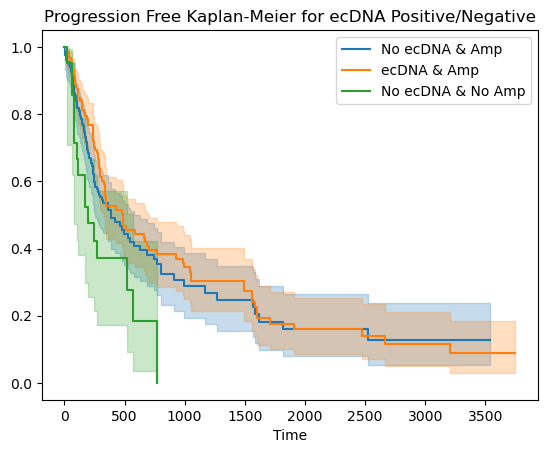

In [15]:
import warnings
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

# Ignore all warnings
warnings.filterwarnings('ignore')

kmf = KaplanMeierFitter()
for status in per_sample_for_km['combined'].unique():
    subset = per_sample_for_km[per_sample_for_km['combined'] == status]
    kmf.fit(subset['pfs'], event_observed=(subset['progressedOrDead'] == True))
    # labels
    kmf.plot(show_censors=False, ci_show=True, label=f'{status}')

# # Add labels and legend
plt.title('Progression Free Kaplan-Meier for ecDNA Positive/Negative')
plt.xlabel("Time")
plt.legend()

In [16]:
from itertools import combinations
from lifelines.statistics import logrank_test

kmf = KaplanMeierFitter()
kmf2 = KaplanMeierFitter()

statuses = per_sample_for_km['combined'].unique()
pairwise_tests = {}

for group1, group2 in combinations(statuses, 2) :
    group1_data = per_sample_for_km[per_sample_for_km['combined'] == group1]
    group2_data = per_sample_for_km[per_sample_for_km['combined'] == group2]

    # Fit KM curves
    kmf.fit(group1_data['pfs'], event_observed=(group1_data['combined'] == 1))
    kmf2.fit(group2_data['pfs'], event_observed=(group2_data['combined'] == 1))
    
    # Perform log-rank test
    result = logrank_test(group1_data['pfs'], group2_data['pfs'], event_observed_A=(group1_data['progressedOrDead'] == True), event_observed_B=(group2_data['progressedOrDead'] == True))
    
    # Store p-value in dictionary
    pairwise_tests[(group1, group2)] = result.p_value

p_values_matrix = pd.DataFrame(index=statuses, columns=statuses)
for (group1, group2), p_value in pairwise_tests.items():
    if group1 != group2:
        p_values_matrix.loc[group1, group2] = p_value
p_values_matrix = p_values_matrix.fillna("")

print("P-values for KM Curves")

styled_matrix = p_values_matrix.iloc[:-1, 1:].style.set_table_styles([{
    'selector': 'th',
    'props': [('border', '1px solid black')]
}, {
    'selector': 'td',
    'props': [('border', '1px solid black')]
}])
styled_matrix

P-values for KM Curves


,ecDNA & Amp,No ecDNA & No Amp
No ecDNA & Amp,0.533966,0.014730
ecDNA & Amp,,0.002375
